#### This Notebook provides an overview of some the open healthcare datasets. 

##### In the process, we will look at how Healthcare Associated Infections (HAI) are affected by the hospital's patient care processes and how HAI in turn affects re-admission rates. Finally, we will look at what patients say about the hospital and how it can be combined with the other datasets providing some insight into contributing factors.

We are going to be looking at datasets for:
    1. Infections associated with hospital stay
    2. Structural Measures in hospitals
    3. Patient Survey (done by HCAHPS (the Hospital Consumer Assessment of Healthcare Providers and Systems))
    4. Re-admissions within 30 days of discharge

In [61]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [57]:
### import modules as needed ###
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
%matplotlib inline

#### Infections metadata ###
### source : http://www.cdc.gov/HAI/infectionTypes.html ###
##### HAIs reported here are:
      1. 'CLABSI':'Central line-associated bloodstream infection'
      2. 'CAUTI':'Catheter-associated Urinary Tract Infection',
      3. 'SSI':'Surgical Site Infection',
      4. 'MRSA':'Methicillin-resistant Staphylococcus aureus'

In [3]:
from io import BytesIO
import requests
import json

# This function accesses a file in your Object Storage. The definition contains your credentials.
# You might want to remove those credentials before you share your notebook.
def get_data(container, filename):
    """This functions returns a StringIO object containing
    the file content from Bluemix Object Storage V3."""

    url1 = ''.join(['https://identity.open.softlayer.com', '/v3/auth/tokens'])
    data = {'auth': {'identity': {'methods': ['password'],
            'password': {'user': {'name': 'member_59d691a96d2d02a70ca61b614023cdb22dcd6136','domain': {'id': '49022de2aced4b7991547f7c5644cbad'},
            'password': 'oA2LS.BM1pH8#Vqu'}}}}}
    headers1 = {'Content-Type': 'application/json'}
    resp1 = requests.post(url=url1, data=json.dumps(data), headers=headers1)
    resp1_body = resp1.json()
    for e1 in resp1_body['token']['catalog']:
        if(e1['type']=='object-store'):
            for e2 in e1['endpoints']:
                        if(e2['interface']=='public'and e2['region']=='dallas'):
                            url2 = ''.join([e2['url'],'/', container, '/', filename])
    s_subject_token = resp1.headers['x-subject-token']
    headers2 = {'X-Auth-Token': s_subject_token, 'accept': 'application/json'}
    resp2 = requests.get(url=url2, headers=headers2)
    return BytesIO(resp2.content)

In [58]:
#### Read Infections data and format ###
infection_id_desc = {
    'HAI_1':'CLABSI',
    'HAI_1a':'CLABSI',
    'HAI_2':'CAUTI',
    'HAI_2a':'CAUTI',
    'HAI_3':'SSI Colon',
    'HAI_4':'SSI Abdominal',
    'HAI_5': 'MRSA',
    'HAI_6':'C.diff'
}

def get_infection_desc(x):
    desc = 'Not Available'
    for d in infection_id_desc.keys():
        if d in x:
            desc = infection_id_desc[d]
    return desc

def make_less_verbose(x):
    if 'Better' in x:
        return 'Better'
    elif 'Worse' in x:
        return 'Worse'
    elif 'No different':
        return 'Same'
    else:
        return 'NA'
    
data_pd = pd.read_csv(get_data('Test1', 'Healthcare_Associated_Infections_-_Hospital.csv'))
data_pd = data_pd.fillna(0)
data_pd.head(5)

,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,Measure Name,Measure ID,Compared to National,Score,Footnote,Measure Start Date,Measure End Date,Location
0,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,2565938310,CLABSI: Lower Confidence Limit,HAI_1_CI_LOWER,No Different than National Benchmark,0.117,0,01/01/2015,09/30/2015,"2505 U S HIGHWAY 431 NORTH\nBOAZ, AL 35957\n"
1,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,2565938310,CLABSI: Upper Confidence Limit,HAI_1_CI_UPPER,No Different than National Benchmark,2.310,0,01/01/2015,09/30/2015,"2505 U S HIGHWAY 431 NORTH\nBOAZ, AL 35957\n"
2,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,2565938310,CLABSI: Number of Procedures,HAI_1_DOPC_DAYS,No Different than National Benchmark,2109,0,01/01/2015,09/30/2015,"2505 U S HIGHWAY 431 NORTH\nBOAZ, AL 35957\n"
3,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,2565938310,CLABSI: Predicted Cases,HAI_1_ELIGCASES,No Different than National Benchmark,2.860,0,01/01/2015,09/30/2015,"2505 U S HIGHWAY 431 NORTH\nBOAZ, AL 35957\n"
4,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,2565938310,CLABSI: Observed Cases,HAI_1_NUMERATOR,No Different than National Benchmark,2,0,01/01/2015,09/30/2015,"2505 U S HIGHWAY 431 NORTH\nBOAZ, AL 35957\n"


In [5]:
data = sqlContext.createDataFrame(sc.parallelize(data_pd.to_dict(orient='records')))
remove_cols = ['Hospital Name','Phone Number','ZIP Code','Footnote','Address','Location']
for col in remove_cols:
    data = data.drop(data[col])
    
#filter data as needed 
data = data.filter(data['Measure Name'].like('%Observed%') |\
                data['Measure Name'].like('%Predicted%') |\
                data['Measure Name'].like('%Days%')|\
               data['Measure Name'].like('%Procedures%'))

data = data.filter((~data.Score.isNull()) &\
                (data.Score!='Not Available') &\
                (data['Compared to National']!='Not Available'))

#change column data
from pyspark.sql.types import FloatType, StringType, IntegerType
from pyspark.sql.functions import UserDefinedFunction

udf1 = UserDefinedFunction(lambda x:str(x).replace(':',''),StringType())
udf2 = UserDefinedFunction(lambda x: make_less_verbose(x),StringType())

data = data.withColumn('Score',data.Score.cast(FloatType()))
data = data.withColumn('Measure Name',udf1(data['Measure Name']))
data = data.withColumn('Compared to National',udf2(data['Compared to National']))

#add columns as needed
measure_names = data.select('Measure Name').distinct().collect()
unique_measures = data.select('Measure ID').distinct().collect()
measures = {m['Measure ID']:i for m,i in zip(unique_measures,range(len(unique_measures)))}

udf_measure = UserDefinedFunction(lambda x:measures[x],IntegerType())
data = data.withColumn('measures',udf_measure(data['Measure ID']))

udf_infection = UserDefinedFunction(lambda x:get_infection_desc(x),StringType())
data = data.withColumn('infection',udf_infection(data['Measure ID']))

udf_measure_name= UserDefinedFunction(lambda x:' '.join(x.split(' ')[1:]),StringType())
data = data.withColumn('Measure Name',udf_measure_name(data['Measure Name']))

data = data.filter((~data['Measure ID'].like('%HAI_1a%')) |\
                   (~data['Measure ID'].like('%HAI_2a%')))

/usr/local/src/spark20master/spark/python/pyspark/sql/session.py:336: UserWarning: Using RDD of dict to inferSchema is deprecated. Use pyspark.sql.Row instead
  warnings.warn("Using RDD of dict to inferSchema is deprecated. "


In [6]:
import pyspark.sql.functions as F

infections_pivoted = data.select('Provider ID','infection','State','Measure Name','Score')\
                         .groupBy('Provider ID','infection','State')\
                         .pivot('Measure Name').agg(F.avg('Score'))\
                         .fillna(0)
        
infections_pivoted = infections_pivoted.withColumn('Number of Procedures',
                        infections_pivoted['Number of Procedures'] +\
                        infections_pivoted['Abdominal, Number of Procedures']+\
                        infections_pivoted['Colon, Number of Procedures'])

infections_pivoted = infections_pivoted.withColumn('Observed Cases',
                        infections_pivoted['Observed Cases']+\
                        infections_pivoted['Abdominal Observed Cases']+\
                        infections_pivoted['Colon Observed Cases'])

infections_pivoted = infections_pivoted.withColumn('Predicted Cases',
                      infections_pivoted['Predicted Cases']+\
                      infections_pivoted['Abdominal Predicted Cases']+\
                      infections_pivoted['Colon Predicted Cases'])

infections_pivoted = infections_pivoted.withColumn('Days',
                      infections_pivoted['Central Line Days']+\
                      infections_pivoted['Patient Days']+\
                      infections_pivoted['Urinary Catheter Days'])

cols_to_remove = ['Abdominal, Number of Procedures','Colon, Number of Procedures',
                  'Abdominal Observed Cases','Colon Observed Cases',
                  'Abdominal Predicted Cases','Colon Predicted Cases',
                  'Central Line Days','Patient Days','Urinary Catheter Days']
for col in cols_to_remove:
    infections_pivoted = infections_pivoted.drop(infections_pivoted[col])

In [59]:
infections_pivoted.toPandas().head(3)

,Provider ID,infection,State,Number of Procedures,Observed Cases,Predicted Cases,Days
0,50517,CAUTI,CA,4096.0,0.0,4.080500,1483.0
1,390102,C.diff,PA,0.0,54.0,54.205002,63828.0
2,340050,SSI Colon,NC,74.0,2.0,2.584000,0.0


### Patient Data 
#### Patients are asked a  number of questions about their experience, we will work with the ratings they provided (1-5) for the following:
       1. Cleanliness
       2. Nurse & Doctor communication
       3. Communications about medicine
       4. Pain Management
       5. Quietness
       6. Discharge & Care-transitioning

In [7]:
### Read patient survey data - Spark ###
patient_data = pd.read_csv(get_data('Test1', 'Patient_survey__HCAHPS__-_Hospital.csv'))
patient_data = patient_data.fillna(0)
patient_data = sqlContext.createDataFrame(sc.parallelize(patient_data.to_dict(orient='records')))
patient_data = patient_data.select('Provider ID','HCAHPS Measure ID',
            'HCAHPS Answer Description','Patient Survey Star Rating')
patient_data = patient_data.filter((patient_data['Patient Survey Star Rating']!='Not Applicable')&\
                                  (patient_data['Patient Survey Star Rating']!='Not Available'))

#Pivot table 
patient_data_pivoted = patient_data.groupBy('Provider ID')\
                                   .pivot('HCAHPS Answer Description')\
                                   .agg(F.avg('Patient Survey Star Rating'))\
                                   .fillna(0)

/usr/local/src/spark20master/spark/python/pyspark/sql/session.py:336: UserWarning: Using RDD of dict to inferSchema is deprecated. Use pyspark.sql.Row instead
  warnings.warn("Using RDD of dict to inferSchema is deprecated. "


In [60]:
patient_data_pivoted.toPandas().head(5)

,Provider ID,Care transition - star rating,Cleanliness - star rating,Communication about medicines - star rating,Discharge information - star rating,Doctor communication - star rating,Nurse communication - star rating,Overall hospital rating - star rating,Pain management - star rating,Quietness - star rating,Recommend hospital - star rating,Staff responsiveness - star rating,Summary star rating
0,340147,2.0,2.0,4.0,4.0,3.0,3.0,3.0,3.0,3.0,2.0,3.0,3.0
1,50002,1.0,2.0,2.0,3.0,3.0,3.0,3.0,2.0,2.0,3.0,2.0,2.0
2,360362,4.0,4.0,4.0,5.0,3.0,5.0,5.0,4.0,5.0,5.0,5.0,4.0
3,60016,3.0,2.0,3.0,4.0,3.0,3.0,3.0,3.0,3.0,2.0,3.0,3.0
4,150157,3.0,2.0,3.0,3.0,4.0,3.0,4.0,4.0,4.0,4.0,3.0,3.0


### What is SIR?
##### SIR (Standardized infection Ratio) is the an important ratio used to judge hospital performance in dealing with HAIs. It is calculated as #actual HAI cases/#Predicted cases. This number is used to determine whether the hospital is better than the national baseline, same or worse.

 (We calculated SIR since it is not a part of the dataset and found it consistent with the comparison to national average)

In [10]:
### Calc SIR ###
d = data.filter(data.infection=='CLABSI')\
         .select('Provider ID','State','Score','Compared to National','Measure Name')
d = d.groupBy('Provider ID','Compared to National')\
     .pivot('Measure Name')\
     .agg(F.avg('Score'))
d = d.withColumn('SIR',d['Observed Cases']/d['Predicted Cases'])
d.select('Provider ID','SIR').show(5)

+-----------+-------------------+
|Provider ID|                SIR|
+-----------+-------------------+
|     230254|0.48208259297654044|
|     240004|0.24177948795576942|
|     220063| 0.5892751822419888|
|     230302|  0.578751560266797|
|     190046| 0.7155955335675541|
+-----------+-------------------+
only showing top 5 rows



In [11]:
### Merging infections and patient survey ###
infections = infections_pivoted.groupBy('Provider ID','State')\
                             .pivot('infection').agg(F.avg('Observed Cases'))
infections_and_survey = infections.join(patient_data,on='Provider ID',how='left')

### infections as a % of procedures/patient days ###
udf = UserDefinedFunction(lambda x:round(x,2),FloatType())
infections_pct = infections_pivoted.withColumn('pct',
    infections_pivoted['Observed Cases']*100/(infections_pivoted['Number of Procedures']+infections_pivoted['Days']))

infections_pct = infections_pct.withColumn('pct',udf(infections_pct['pct']))
infections_pct = infections_pct.groupBy('Provider ID','State')\
                              .pivot('infection')\
                              .agg(F.avg('pct'))
                
infections_pct_and_survey = infections_pct.join(patient_data_pivoted,on='Provider ID',how='left')

### Group by state and calculate mean for every state ###
avged_columns = infections_and_survey.columns
avged_columns.remove('Provider ID')
avged_columns.remove('State')
infections_pct_and_survey = infections_pct_and_survey.withColumnRenamed('C.diff','C_diff')
infections_pct_and_survey = infections_pct_and_survey.withColumn('Care transition - star rating',
            infections_pct_and_survey['Care transition - star rating'].cast(FloatType()))
#infections_and_survey.printSchema()
data_by_state = infections_pct_and_survey.groupby('State')\
                .mean('C_diff', 'CAUTI', 'CLABSI', 'MRSA', 'SSI Abdominal', 
                       'SSI Colon', 'Care transition - star rating')

#### We will look at how patient survey data is indicative of the state of HAIs in hospitals.
##### We see a negative correlation between patient's ratings and the number of HAI cases for every type of HAI.
      
(In the below cell, change the y_axis value to whichever star-rated question you want to visualize.)

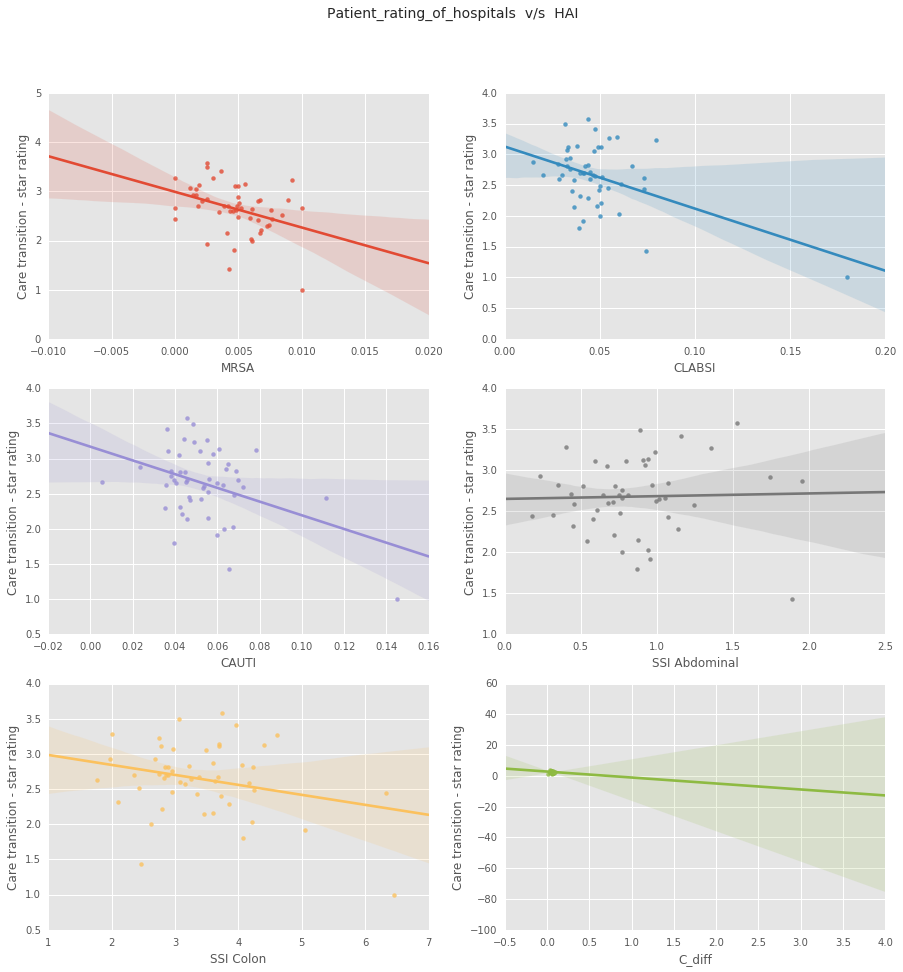

In [17]:
### Visualize Patient_rating_of_hospitals  v/s  HAI ###
data_by_state = data_by_state.toPandas()
data_by_state.columns = [col if 'avg' not in col else col[4:-1] for col in data_by_state.columns]
plt.style.use('ggplot')
fig, ax = plt.subplots(nrows=3, ncols=2,figsize=(15,15))
ax = ax.flatten()
y_axis = 'Care transition - star rating'
infection_id_desc.pop('HAI_2a')
infection_id_desc.pop('HAI_1a')
infection_id_desc['HAI_6']='C_diff'

for i,infec in enumerate(infection_id_desc.items()):
    infec = infec[1]
    sns.regplot(x =infec, y=y_axis,data=data_by_state,ax=ax[i])
plt.suptitle('Patient_rating_of_hospitals  v/s  HAI',fontsize='14')

### Hospital Structure data

###### This data compares a set procedures followed in a hospital. Some hospitals have these available while some do not; these procedures/structures are:
         1. Ability to receive lab results electronically & track patients between visits electronically
         2. General surgery & Nursing registries
         3. Safe surgery checklists (inpatient & outpatient)

In [18]:
### Read in hospital structure data ####
def encode(x):
    if x in ['Y','Yes']:
        return 1
    elif x in ['N','No']:
        return 0
    elif x=='Not Available':
        return 0
    else:
        return -1

udf = UserDefinedFunction(lambda x:encode(x),IntegerType())    
struct = pd.read_csv(get_data('Test1','Structural_Measures_-_Hospital.csv'))
print (struct['Measure Response'].unique())
struct = sqlContext.createDataFrame(sc.parallelize(struct.to_dict(orient='records')))
struct = struct.withColumn('Measure Response',udf(struct['Measure Response']))
struct = struct.filter(struct['Measure Response']!=-1)

struct_pivot = struct.groupBy('Provider ID').pivot('Measure Name')\
                     .agg(F.avg('Measure Response'))
struct_pivot = struct_pivot.drop(struct_pivot['Multispecialty surgical registry'])
struct_pivot = struct_pivot.drop(struct_pivot['Cardiac surgery registry'])
struct_pivot  = struct_pivot.fillna(0)


['Yes' 'Does not have a Cardiac Surgery Program' 'N' 'Y' 'No'
 'Not Available']


/usr/local/src/spark20master/spark/python/pyspark/sql/session.py:336: UserWarning: Using RDD of dict to inferSchema is deprecated. Use pyspark.sql.Row instead
  warnings.warn("Using RDD of dict to inferSchema is deprecated. "


In [19]:
### Combine with HAI data ###
m = infections_and_survey.join(struct_pivot,on='Provider ID',how='inner')
m = m.withColumnRenamed('C.diff','C_diff')
norm = m.groupby('State').mean('C_diff', 'CAUTI', 'CLABSI', 'MRSA', 'SSI Abdominal', 
                       'SSI Colon','Safe surgery checklist use (outpatient)')
norm = norm.toPandas()
norm.columns = [col if 'avg' not in col else col[4:-1] for col in norm.columns]
norm.columns

Index(['State', 'C_diff', 'CAUTI', 'CLABSI', 'MRSA', 'SSI Abdominal',
       'SSI Colon', 'Safe surgery checklist use (outpatient)'],
      dtype='object')

#### We investigate the above structure data to determine if it has any impact on the rate of HAIs.
###### We observe that there is a negative correlation between Safe surgery checklists (outpatient) and some HAIs (CAUTI, CLABSI, MRSA; which are also the most prolific instances of HAI). 

This is intuitively satisfying because patients (outpatients) who are not given adequate instructions post surgery are most likely to contract these types of infections.

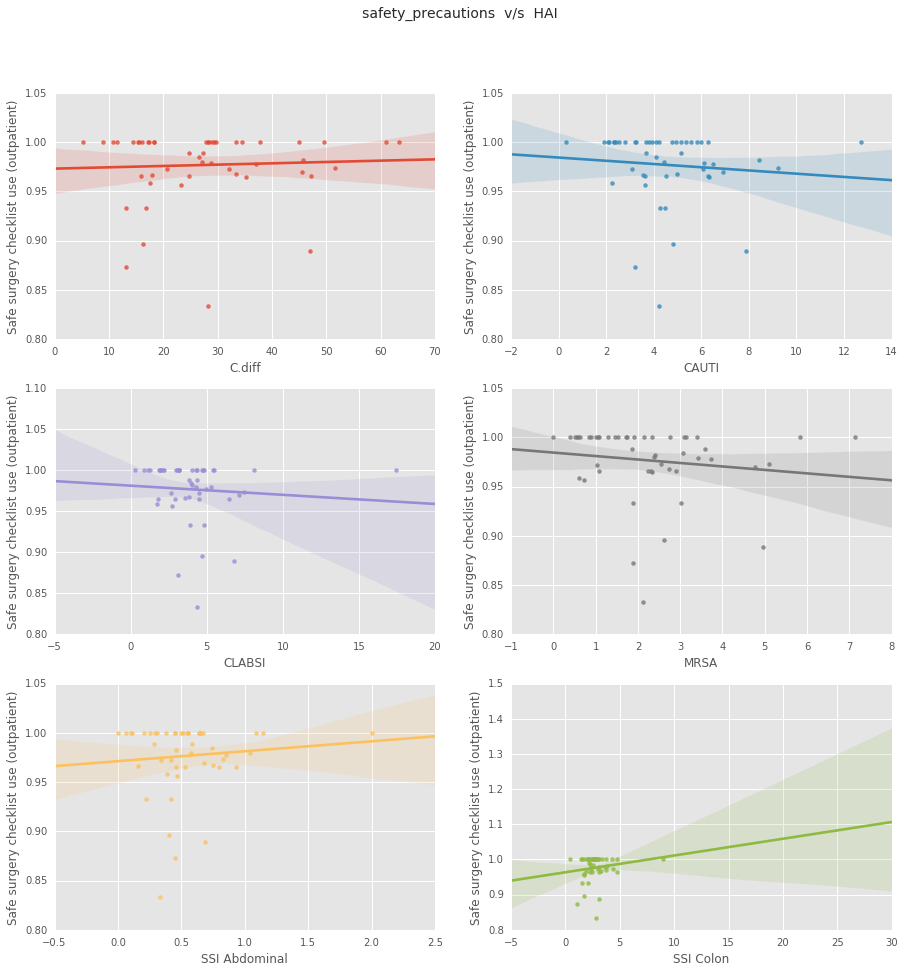

In [20]:
norm = pd.read_csv(get_data('Test1','viz_data.csv'))
y = 'Safe surgery checklist use (outpatient)'
x_values = norm.columns[2:8]
fig, axes = plt.subplots(nrows=3,ncols=2,figsize=(15,15))
ax = axes.flatten()

for i in range(len(x_values)):
    sns.regplot(x=x_values[i],y=y,data=norm,ax=ax[i])
plt.suptitle('safety_precautions  v/s  HAI',fontsize=14)

#### Lastly, we look at re-admissions data. 
###### Re-admissions are due to the following factors:
              1. COPD:Chronic obstructive Pulmonary Diseases
              2. HF:Heart Failure
              3. HIP:Hip-Knee
              4. PN:Pneumonia
              5. AMI:Acute Myocardial Infarction (Heart Attack)
###### An "excess ratio" is calcuated as #expected re-admissions/predicted re-admissions for each of these conditions. This is a crucial figure for hospitals since it determines the amount of funding it will receive from Medicare. Hospitals having the excess ratio >1 are penalized and may receive upto 3% less funding from Medicare.

In [21]:
### Read readmissions data ###
### Concentrate on excess re-admissions ratio factor, >1 is bad and hospitals receive less funding from CMS because of this ###
meta_re_admissions = {'COPD':'Chronic obstructive Pulmonary Diseases',
                      'HF':'Heart Failure',
                      'HIP':'Hip-Knee',
                      'PN':'Pneumonia',
                      'AMI':'Acute Myocardial Infarction (Heart Attack)'} #medical name for a heart attack
re_admissions = pd.read_csv(get_data('Test1','Hospital_Readmissions_Reduction_Program.csv'))
re_admissions = sqlContext.createDataFrame(sc.parallelize(re_admissions.to_dict(orient='records')))

re_admissions = re_admissions.filter((re_admissions['Excess Readmission Ratio']!='Not Available')&\
                  (re_admissions['Number of Readmissions']!='Too Few to Report'))
re_admissions = re_admissions.drop(re_admissions['Footnote'])

udf1 = UserDefinedFunction(lambda x:x.split('-')[2], StringType())
re_admissions = re_admissions.withColumn('Measure Name',udf1(re_admissions['Measure Name']))
re_admissions = re_admissions.withColumn('Excess Readmission Ratio',
                            re_admissions['Excess Readmission Ratio'].cast(FloatType()))
re_admissions = re_admissions.withColumn('Number of Readmissions',
                                    re_admissions['Number of Readmissions'].cast(FloatType()))

/usr/local/src/spark20master/spark/python/pyspark/sql/session.py:336: UserWarning: Using RDD of dict to inferSchema is deprecated. Use pyspark.sql.Row instead
  warnings.warn("Using RDD of dict to inferSchema is deprecated. "


In [22]:
re_admissions.toPandas().head(3)

,End Date,Excess Readmission Ratio,Expected Readmission Rate,Hospital Name,Measure Name,Number of Discharges,Number of Readmissions,Predicted Readmission Rate,Provider Number,Start Date,State
0,30-JUN-14,0.9502,19.3,THOMAS HOSPITAL,COPD,166,27.0,18.4,10100,01-JUL-11,AL
1,30-JUN-14,0.9587,20.8,THOMAS HOSPITAL,HF,343,66.0,19.9,10100,01-JUL-11,AL
2,30-JUN-14,1.0221,4.8,THOMAS HOSPITAL,HIP,641,32.0,4.9,10100,01-JUL-11,AL


In [23]:
### Format data and merge with infections ###
# Disclaimer: re-admissions and HAI not captured in the same time period
re_admissions_pivoted = re_admissions.groupBy('Hospital Name','Provider Number','State')\
                                .pivot('Measure Name')\
                                .mean('Number of Readmissions','Excess Readmission Ratio')  
re_admissions_pivoted  = re_admissions_pivoted.withColumnRenamed('Provider Number','Provider ID')

infections_and_read = infections.join(re_admissions_pivoted,on='Provider ID',how='inner')

#### We try to see if the hospitals having high excess re_admission ratios are the very same ones have high HAIs.

We see that there is some degree of positive correlation between rising re_admission ratios and HAIs suggesting the hospitals can take the same set of measure and try to reduce both HAIs and re_admissions.

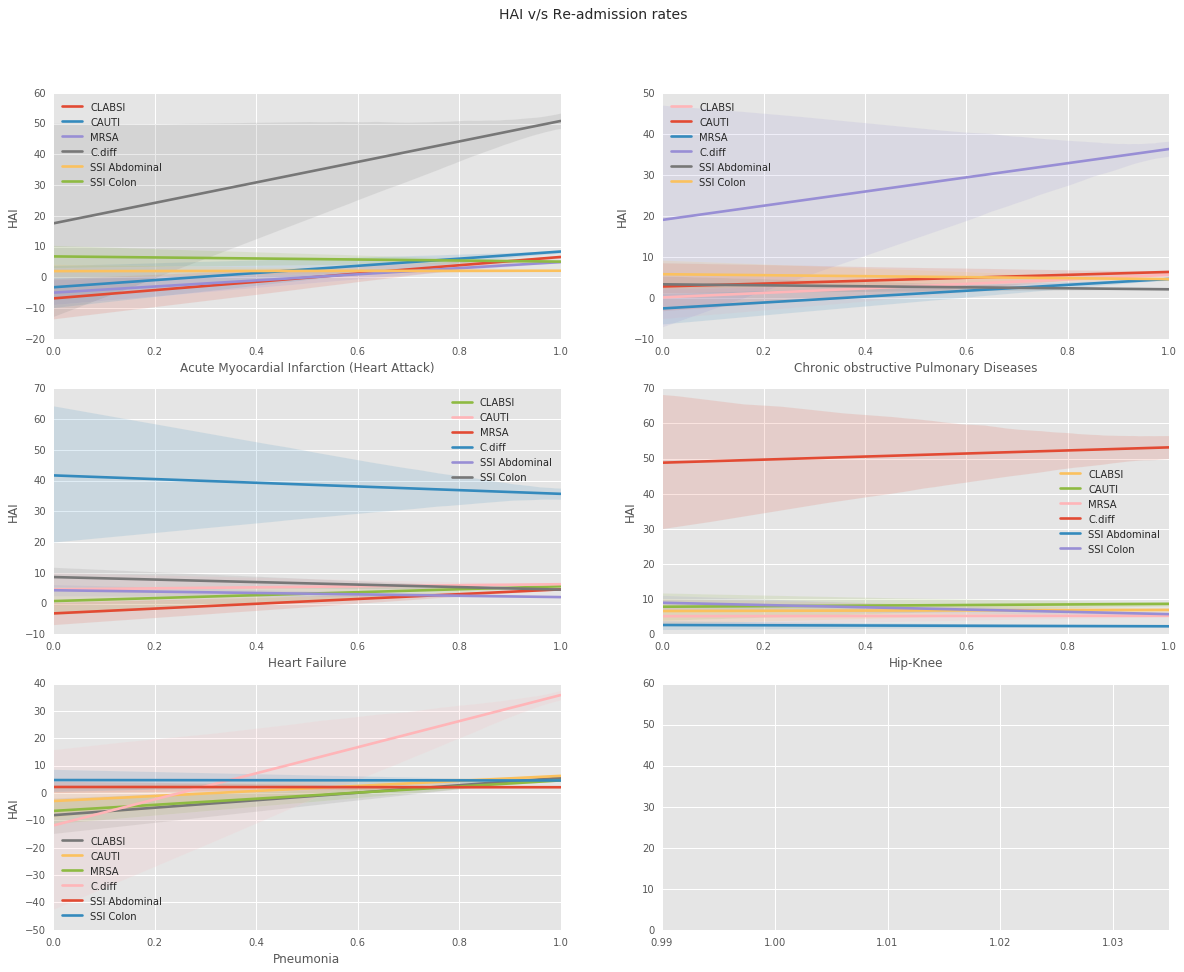

In [26]:
### Viz re-admission ratios v/s infections ###
d = infections_and_read.toPandas()
d.columns = ['Provider ID', 'State', 'C.diff', 'CAUTI', 'CLABSI', 'MRSA',
       'SSI Abdominal', 'SSI Colon', 'Hospital Name', 'State',
       'Number of Readmissions_AMI',
       'Excess Readmission Ratio_AMI',
       'Number of Readmissions_COPD',
       'Excess Readmission Ratio_COPD',
       'Number of Readmissions_HF',
       'Excess Readmission Ratio_HF',
       'Number of Readmissions_HIP',
       'Excess Readmission Ratio_HIP',
       'Number of Readmissions_PN',
       'Excess Readmission Ratio_PN']

fig, axes = plt.subplots(nrows=3,ncols=2,figsize=(20,15))
axes = axes.flatten()
for i,r in enumerate(['Excess Readmission Ratio_AMI','Excess Readmission Ratio_COPD',
                      'Excess Readmission Ratio_HF','Excess Readmission Ratio_HIP',
                      'Excess Readmission Ratio_PN']):
    a = sns.regplot(r,'CLABSI',data=d,ax=axes[i],scatter=False,label='CLABSI')
    sns.regplot(r,'CAUTI',data=d,ax=axes[i],scatter=False,label='CAUTI')
    sns.regplot(r,'MRSA',data=d,ax=axes[i],scatter=False,label='MRSA')
    sns.regplot(r,'C.diff',data=d,ax=axes[i],scatter=False,label='C.diff')
    sns.regplot(r,'SSI Abdominal',data=d,ax=axes[i],scatter=False,label='SSI Abdominal')
    sns.regplot(r,'SSI Colon',data=d,ax=axes[i],scatter=False,label='SSI Colon')
    a.set_ylabel('HAI')
#     a.set_xlim([d[r].min(),d[r].max()])
    a.set_xlabel(meta_re_admissions[r.split('_')[1]])
    a.legend(loc='best')
plt.suptitle('HAI v/s Re-admission rates',fontsize=14)

In [48]:
### register data frames as tables ###
# re_admissions = re_admissions.drop(re_admissions['End Date'])
# re_admissions = re_admissions.drop(re_admissions['Start Date'])
for col in re_admissions.columns:
    re_admissions = re_admissions.withColumnRenamed(col,'_'.join(col.split(' ')))

infections_pct_and_survey.registerTempTable('infections_and_survey')
re_admissions.registerTempTable('re_admissions')

In [55]:
### Perform interactive queries ###
query = """
select  * 
from re_admissions 
where State='NY'
and Excess_Readmission_Ratio > 1
order by Excess_Readmission_Ratio desc
limit 5
"""
sqlContext.sql(query).toPandas()

,Excess_Readmission_Ratio,Expected_Readmission_Rate,Hospital_Name,Measure_Name,Number_of_Discharges,Number_of_Readmissions,Predicted_Readmission_Rate,Provider_Number,State
0,1.4631,5.2,ST CATHERINE OF SIENA HOSPITAL,HIP,157,19.0,7.7,330401,NY
1,1.3984,5.8,GOOD SAMARITAN HOSPITAL MEDICAL CENTER,HIP,121,16.0,8.1,330286,NY
2,1.3941,5.8,MONTEFIORE NEW ROCHELLE HOSPITAL,HIP,260,27.0,8.0,330184,NY
3,1.2897,22.9,ST JOHN'S RIVERSIDE HOSPITAL,HF,661,211.0,29.5,330208,NY
4,1.2803,21.7,BETH ISRAEL MEDICAL CENTER,HF,1125,328.0,27.8,330169,NY
